In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import torch


### Preliminary Testing of Newton's Method

In [2]:
%load_ext autoreload
%autoreload 2
from newton import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer, AdamOptimizer

In [3]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X.double(), y.double()

X, y = classification_data(noise = 0.5)

In [4]:
opt = NewtonOptimizer()
loss_arr = []
for _ in range(3300):
    loss = opt.loss(X, y)
    loss_arr.append(loss)
    opt.step(X, y, alpha = 0.1)

In [5]:
opt2 = GradientDescentOptimizer()
loss_arr2 = []
for _ in range(120):
    loss = opt2.loss(X, y)
    loss_arr2.append(loss)
    opt2.step(X, y, alpha = 0.1, beta = 0)

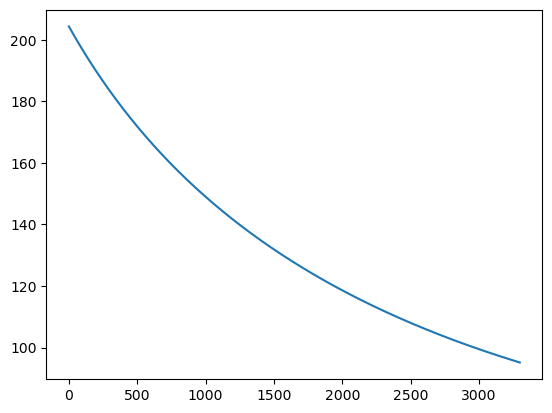

In [6]:
plt.plot(loss_arr)

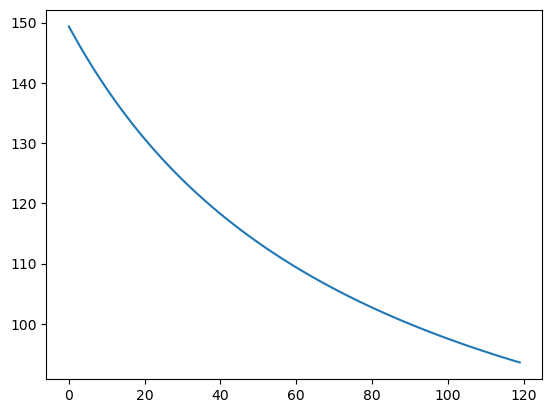

In [7]:
plt.plot(loss_arr2)

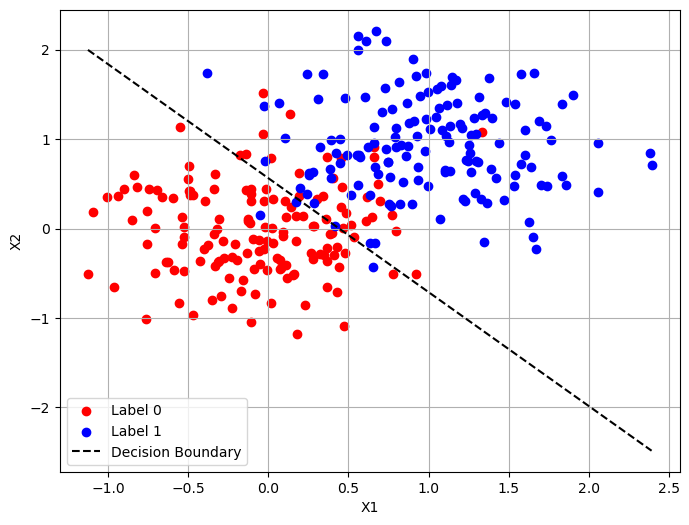

In [8]:
def plot_data_and_w(X, y, w):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label='Label 0')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Label 1')

    # Decision boundary: w0*x + w1*y + w2 = 0
    x_vals = torch.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    if w[1] != 0:
        y_vals = -(w[0] * x_vals + w[2]) / w[1]
        plt.plot(x_vals, y_vals, 'k--', label='Decision Boundary')

    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_data_and_w(X, y, opt.w)

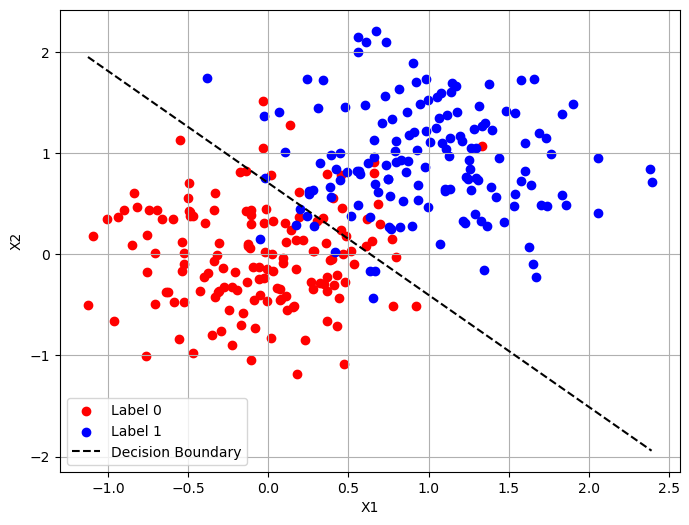

In [9]:
def plot_data_and_w(X, y, w):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label='Label 0')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Label 1')

    # Decision boundary: w0*x + w1*y + w2 = 0
    x_vals = torch.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    if w[1] != 0:
        y_vals = -(w[0] * x_vals + w[2]) / w[1]
        plt.plot(x_vals, y_vals, 'k--', label='Decision Boundary')

    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_data_and_w(X, y, opt2.w)

In [10]:
print(opt.w, opt2.w)

tensor([ 1.6637,  1.3060, -0.7354], dtype=torch.float64) tensor([ 1.4493,  1.3094, -0.9240], dtype=torch.float64)


Very similar w values.

### Newton's Method Experiments

It took me a long time to find a dataset that worked well for Newton's method. Since the step function finds the inverse of the Hessian Matrix, I was running into issues where the Hessian was singular and therefore could not be inverted. I tried using pinverse to approximate the inverse, but unfortunately that slowed down the algorithm drastically.

In [11]:
df = pd.read_csv("/Users/ellisterling/Documents/spring25/csci0451/ellisterling.github.io/posts/newton/data/Titanic-Dataset.csv")
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [12]:
filter = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Survived"]

<Axes: xlabel='Pclass', ylabel='count'>

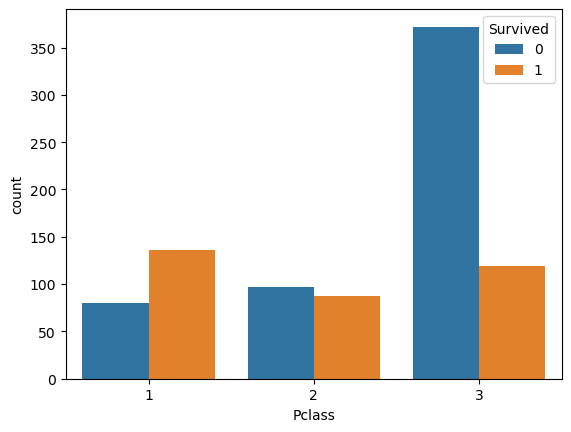

In [13]:
# fig, ax = plt.subplots(1, 1, figsize = (6, 4))
# hist = ax.hist(df['Location'], bins = 50, color = "steelblue", alpha = 0.6, linewidth = 1, edgecolor = "black")
# |sns.countplot(df[df["Preference"] == 0], x = "Environmental_Concerns", hue = "Preference")
# sns.scatterplot(df, x = "Proximity_to_Mountains", y = "Vacation_Budget", hue = "Preference")
sns.countplot(df, x = "Pclass", hue = "Survived")

In [14]:
df.groupby("Survived")["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [15]:
df = df[filter]
df = df.dropna()
df = pd.get_dummies(df)
df["Survived"]

0      0
1      1
2      1
3      1
4      0
      ..
885    0
886    0
887    1
889    1
890    0
Name: Survived, Length: 714, dtype: int64

In [16]:
df_train, df_test = train_test_split(df, test_size = 0.2)
X_train = df_train.drop("Survived", axis=1)
y_train = df_train["Survived"]
X_test = df_test.drop("Survived", axis=1)
y_test = df_test["Survived"]

In [17]:
X_train_tensor = torch.from_numpy(X_train.to_numpy().astype(float))
X_test_tensor = torch.from_numpy(X_test.to_numpy().astype(float))
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float)


In [18]:
X_train_tensor = X_train_tensor.double()
X_train_tensor
y_train_tensor = y_train_tensor.double()
X_test_tensor = X_test_tensor.double()
y_test_tensor = y_test_tensor.double()

In [19]:
opt3 = NewtonOptimizer()
loss_arr = []
X_train

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male
532,3,17.0,1,1,7.2292,False,True
338,3,45.0,0,0,8.0500,False,True
840,3,20.0,0,0,7.9250,False,True
151,1,22.0,1,0,66.6000,True,False
705,2,39.0,0,0,26.0000,False,True
...,...,...,...,...,...,...,...
146,3,27.0,0,0,7.7958,False,True
155,1,51.0,0,1,61.3792,False,True
285,3,33.0,0,0,8.6625,False,True
881,3,33.0,0,0,7.8958,False,True


In [20]:
opt3.w

In [21]:
for _ in range(5000):
    # add other stuff to e.g. keep track of the loss over time.
    loss = opt3.loss(X_train_tensor, y_train_tensor)
    loss_arr.append(loss)
    opt3.step(X_train_tensor, y_train_tensor, alpha = 0.25)

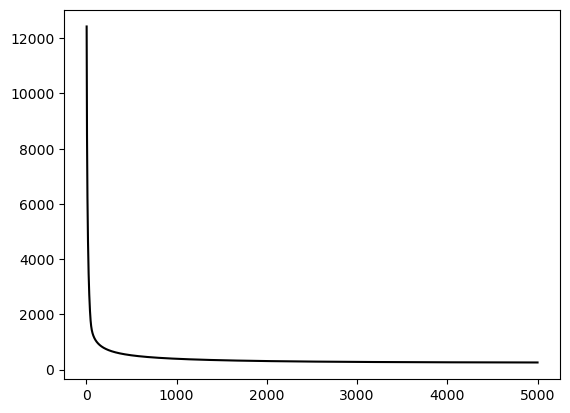

In [22]:
plt.plot(torch.arange(1, len(loss_arr)+1), loss_arr, color = "black")

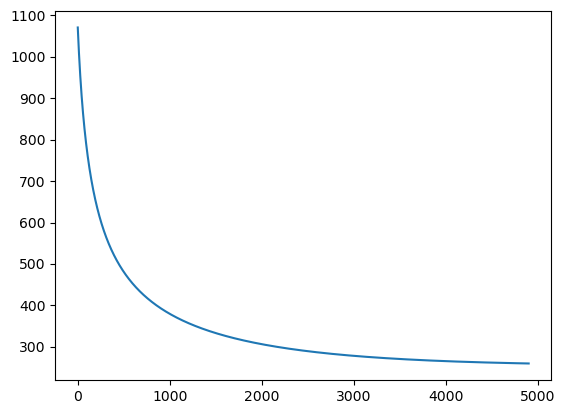

In [23]:
plt.plot(loss_arr[100:])

In [24]:
loss_arr[2000:]

[tensor(310.5317, dtype=torch.float64),
 tensor(310.4860, dtype=torch.float64),
 tensor(310.4403, dtype=torch.float64),
 tensor(310.3947, dtype=torch.float64),
 tensor(310.3490, dtype=torch.float64),
 tensor(310.3035, dtype=torch.float64),
 tensor(310.2579, dtype=torch.float64),
 tensor(310.2125, dtype=torch.float64),
 tensor(310.1670, dtype=torch.float64),
 tensor(310.1216, dtype=torch.float64),
 tensor(310.0762, dtype=torch.float64),
 tensor(310.0309, dtype=torch.float64),
 tensor(309.9856, dtype=torch.float64),
 tensor(309.9404, dtype=torch.float64),
 tensor(309.8952, dtype=torch.float64),
 tensor(309.8501, dtype=torch.float64),
 tensor(309.8050, dtype=torch.float64),
 tensor(309.7599, dtype=torch.float64),
 tensor(309.7149, dtype=torch.float64),
 tensor(309.6699, dtype=torch.float64),
 tensor(309.6249, dtype=torch.float64),
 tensor(309.5800, dtype=torch.float64),
 tensor(309.5352, dtype=torch.float64),
 tensor(309.4904, dtype=torch.float64),
 tensor(309.4456, dtype=torch.float64),


In [25]:
opt3.w

tensor([-9.7637e-01, -3.8816e-02, -4.1513e-01, -7.2064e-02,  1.6028e-03,
         4.1965e+00,  2.0960e+00], dtype=torch.float64)

In [26]:
y_test_tensor

tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
        0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
        1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.],
       dtype=torch.float64)

In [27]:
predicted = opt3.predict(X_test_tensor)
predicted

tensor([0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
        0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
        1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.])

In [28]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(y_test_tensor, predicted)
C

array([[71,  9],
       [17, 46]])

In [30]:
(71+46)/143

0.8181818181818182